# Sberbank Russian Housing Market

### A Kaggle Competition on Making Realty Price Predictions

#### Jack Yip, Chen Trilnik, Haseeb Durrani

In [1]:
# Package imports

import pandas as pd
pd.set_option("display.max_columns", 500)
pd.options.mode.chained_assignment = None

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import random

import re

import numpy as np 
import pandas as pd 

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn import model_selection, preprocessing
from sklearn.preprocessing import LabelEncoder

# Getting the Data 
- Loading the data

In [2]:
train = pd.read_csv("./data/train.csv", parse_dates=['timestamp'])
test = pd.read_csv("./data/test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("./data/macro.csv", parse_dates=['timestamp'])

- Adding variables to aid in splitting the data set after merging train and test

In [3]:
train["SOURCE"] = "TRAIN"
test["price_doc"] = np.nan
test["SOURCE"] = "TEST"

- Merging both the training and test set to impute evenly 

In [4]:
df = train.append(test)
df.index = range(df.shape[0])
df.shape

(38133, 293)

- Merging macro data with data set

In [5]:
df = pd.merge(df, macro, on='timestamp', how='left')
df.shape

(38133, 392)

# Cleaning the data

- Visualizing missingness

/Users/Haseeb/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


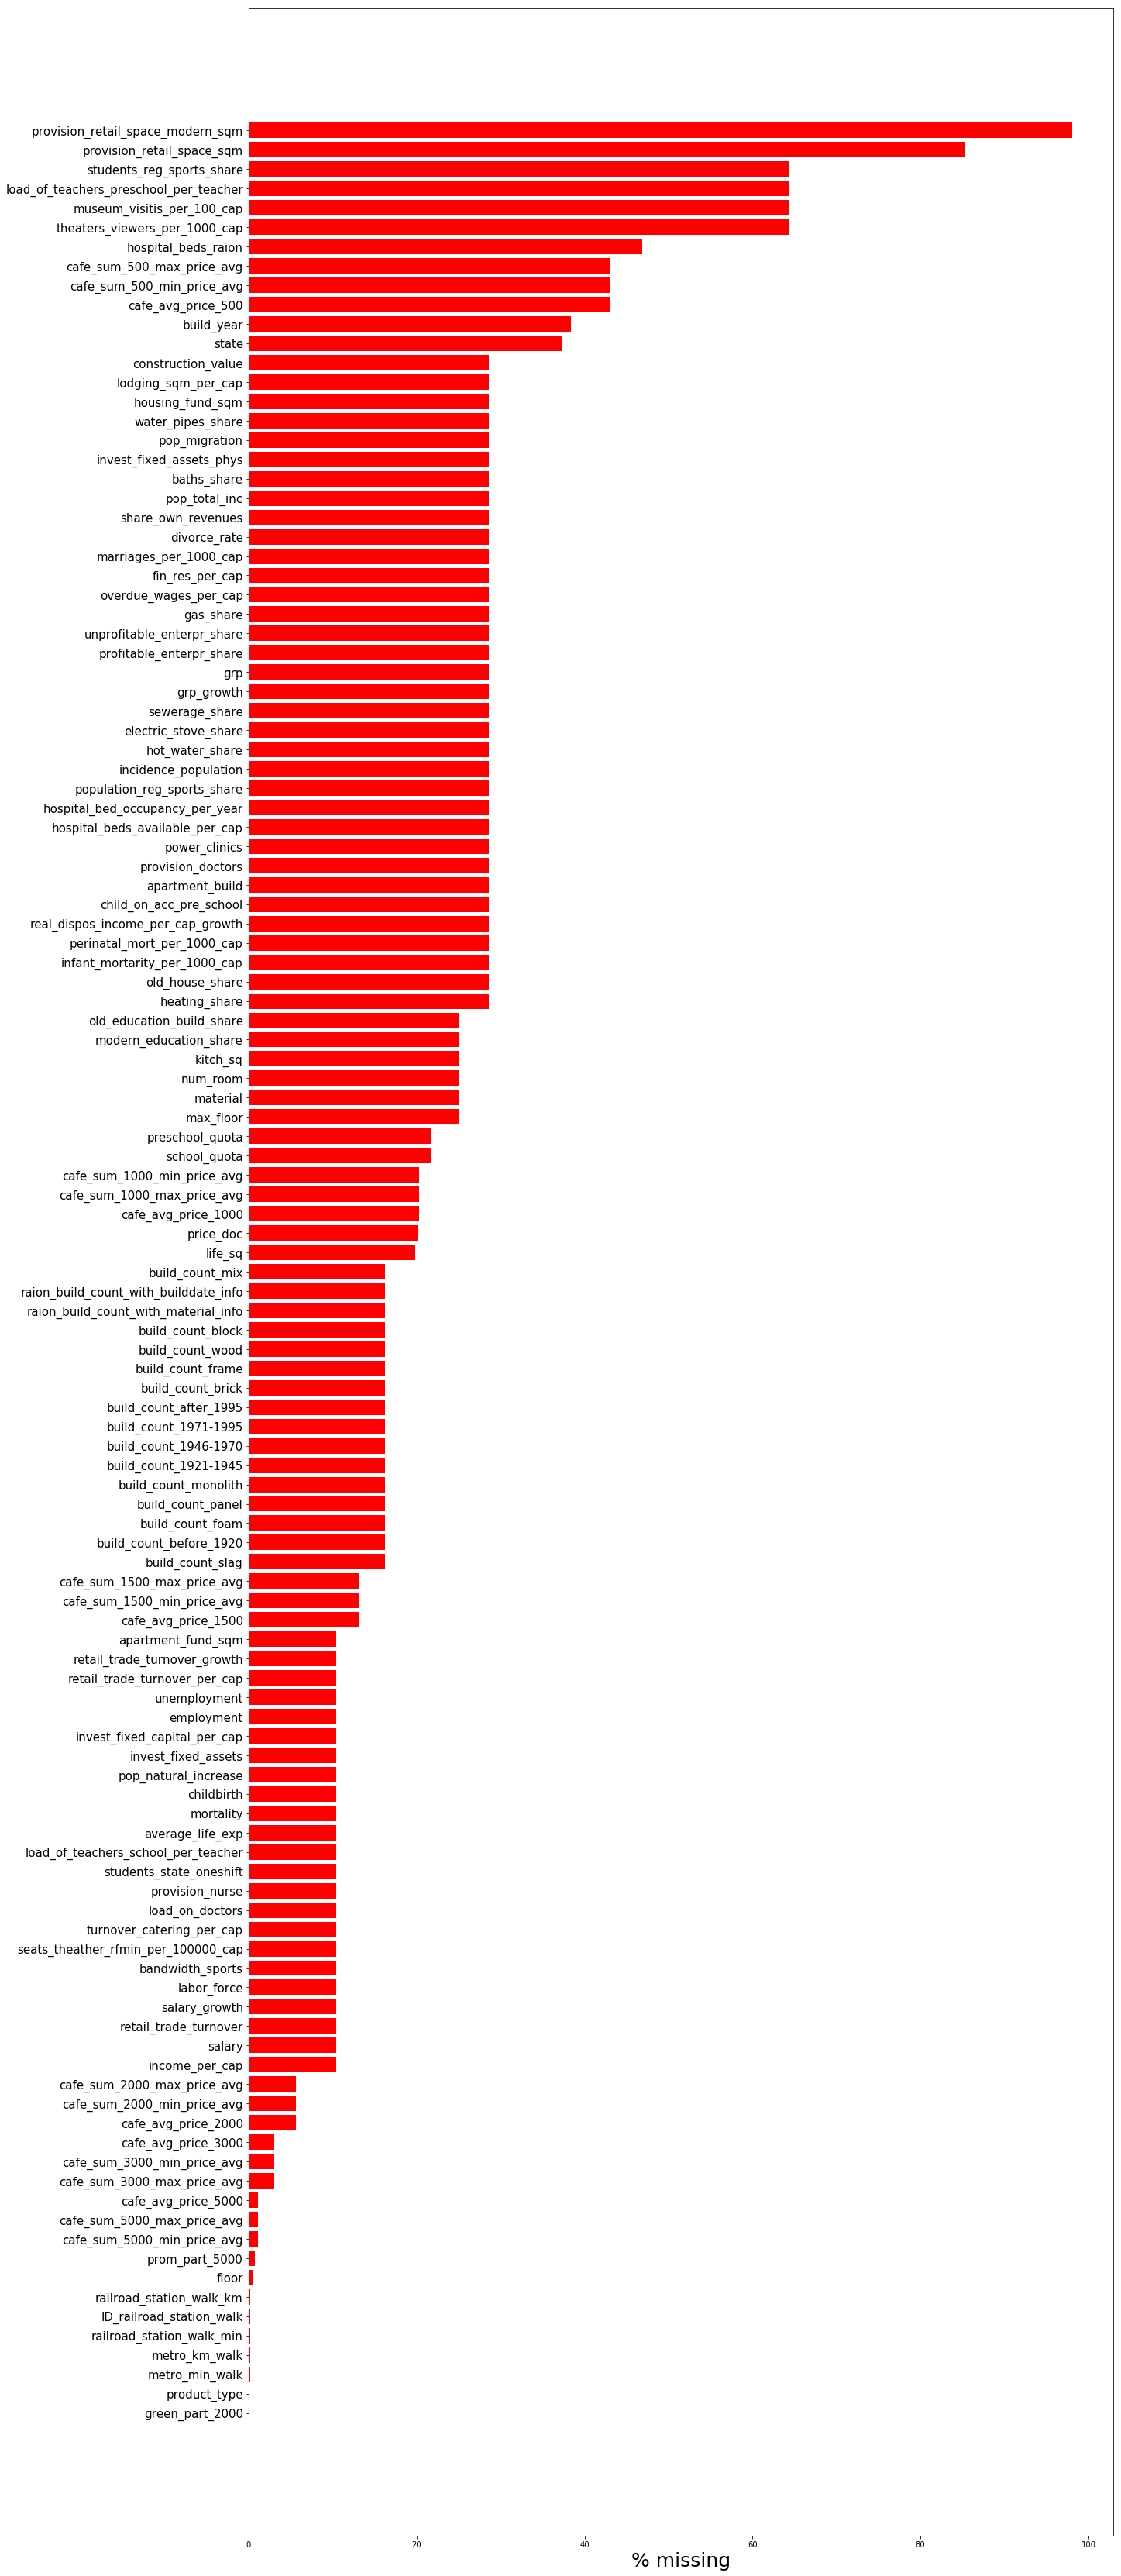

In [6]:
missing = df.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing = missing.ix[missing['missing_count']>0]

missing["perc_missing"] = (missing.missing_count / df.shape[0]) * 100
missing = missing.sort_values(['perc_missing'], ascending=[True])

ind = np.arange(missing.shape[0])
fig, ax = plt.subplots(figsize=(20,60))
rects = ax.barh(ind, missing.perc_missing.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column_name.values, rotation='horizontal', fontsize = 15)
ax.set_xlabel("% missing", fontsize = 25)
plt.show()

In [7]:
# # macro2 = macro.loc[:, ["usdrub", "eurrub", "brent", "micex_cbi_tr", "micex", "micex_rgbi_tr", "rts", "oil_urals", "cpi", 
# #          "balance_trade", "gdp_quart", "ppi", "net_capital_export", "rent_price_4+room_bus", "income_per_cap",
# #          "deposits_growth", "rent_price_2room_bus", "gdp_quart_growth", "rent_price_3room_bus", "rent_price_1room_bus"]]

# missing_macro = macro.isnull().sum(axis=0).reset_index()
# missing_macro.columns = ['column_name', 'missing_count']
# missing_macro = missing_macro.ix[missing_macro['missing_count']>0]

# missing_macro["perc_missing"] = (missing_macro.missing_count / macro.shape[0]) * 100
# missing_macro = missing_macro.sort_values(['perc_missing'], ascending=[False])

# ind = np.arange(missing_macro.shape[0])
# width = 0.9
# fig, ax = plt.subplots(figsize=(20,10))
# rects = ax.bar(ind, missing_macro.perc_missing.values, color='r')
# ax.set_xticks(ind)
# ax.set_xticklabels(missing_macro.column_name.values, rotation='vertical')
# ax.set_ylabel("% missing", fontsize = 15)
# plt.show()

- Missing value counts by feature

In [8]:
missing_df_list = []

for feature in df.columns:
    print "Feature:", feature, "\t Missing Values:", df[feature].isnull().sum(), "\n"
    temp = {"Feature": feature,
           "Missing_Values": df[feature].isnull().sum()}
    missing_df_list.append(temp)
    
missing_df = pd.DataFrame(missing_df_list)

Feature: id 	 Missing Values: 0 

Feature: timestamp 	 Missing Values: 0 

Feature: full_sq 	 Missing Values: 0 

Feature: life_sq 	 Missing Values: 7559 

Feature: floor 	 Missing Values: 167 

Feature: max_floor 	 Missing Values: 9572 

Feature: material 	 Missing Values: 9572 

Feature: build_year 	 Missing Values: 14654 

Feature: num_room 	 Missing Values: 9572 

Feature: kitch_sq 	 Missing Values: 9572 

Feature: state 	 Missing Values: 14253 

Feature: product_type 	 Missing Values: 33 

Feature: sub_area 	 Missing Values: 0 

Feature: area_m 	 Missing Values: 0 

Feature: raion_popul 	 Missing Values: 0 

Feature: green_zone_part 	 Missing Values: 0 

Feature: indust_part 	 Missing Values: 0 

Feature: children_preschool 	 Missing Values: 0 

Feature: preschool_quota 	 Missing Values: 8284 

Feature: preschool_education_centers_raion 	 Missing Values: 0 

Feature: children_school 	 Missing Values: 0 

Feature: school_quota 	 Missing Values: 8280 

Feature: school_education_cent

In [9]:
# Writing to csv file for easy reference

missing_df.to_csv("./features_missing_values.csv")

# full_sq

In [10]:
print df.full_sq.describe()

count    38133.000000
mean        54.111172
std         35.171162
min          0.000000
25%         38.900000
50%         50.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64


## full_sq: Small Values

In [11]:
print df.loc[df.full_sq < df.full_sq.mean() * 0.09, ["id", "sub_area", "life_sq", "full_sq"]], "\n"

ids = df.loc[df.full_sq < df.full_sq.mean() * 0.09, ["id", "sub_area", "kitch_sq", "life_sq", "full_sq"]].id

df.loc[df.full_sq < df.full_sq.mean() * 0.09, "full_sq"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

df["full_sq"].fillna(df.groupby("sub_area")["full_sq"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

print df.loc[df.full_sq < df.full_sq.mean() * 0.09, ["id", "sub_area", "life_sq", "full_sq"]]

          id                 sub_area  life_sq  full_sq
11332  11335     Poselenie Shherbinka    40.00      1.0
16289  16292  Poselenie Voskresenskoe     1.00      1.0
16738  16741  Poselenie Voskresenskoe     1.00      1.0
17194  17197    Pokrovskoe Streshnevo     1.00      1.0
17932  17935  Poselenie Voskresenskoe     0.00      0.0
18600  18603                 Tverskoe     1.00      1.0
22171  22174     Poselenie Vnukovskoe     1.00      1.0
22412  22415              Presnenskoe    47.00      1.0
22722  22725               Nekrasovka     1.00      1.0
22795  22798     Poselenie Shherbinka     1.00      1.0
22871  22874               Nekrasovka     1.00      1.0
23048  23051       Horoshevo-Mnevniki     1.00      1.0
23228  23231        Nagatinskij Zaton     1.00      1.0
23573  23576                 Nagornoe     1.00      1.0
23726  23729               Nekrasovka     1.00      1.0
24296  24299     Poselenie Vnukovskoe    77.00      0.0
24627  24630  Poselenie Voskresenskoe     1.00  

## full_sq: Large Values

In [12]:
print df.loc[df.full_sq > 300, ["id", "sub_area", "life_sq", "full_sq"]], "\n"

ids = df.loc[df.full_sq > 300, ["id", "sub_area", "kitch_sq", "life_sq", "full_sq"]].id

df.loc[df.full_sq > 300, "full_sq"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

df["full_sq"].fillna(df.groupby("sub_area")["full_sq"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

print df.loc[df.full_sq > 300, ["id", "sub_area", "life_sq", "full_sq"]]

          id              sub_area  life_sq  full_sq
128      129            Ivanovskoe    325.0    325.0
1478    1481              Solncevo     20.0    353.0
1610    1613              Ljublino     17.0    394.0
2425    2428        Filevskij Park     17.0    412.0
2780    2783    Troparevo-Nikulino     44.0    729.0
3527    3530  Birjulevo Vostochnoe     22.0   5326.0
3596    3599            Nekrasovka      NaN    388.0
5944    5947             Lianozovo     38.0    634.0
7207    7210      Vyhino-Zhulebino     27.0    461.0
16743  16746          Obruchevskoe      NaN    303.0
18341  18344            Nekrasovka      NaN    634.0
22785  22788              Tverskoe    637.0    637.0
23715  23718              Krjukovo      NaN    603.0
27793  27796        Filevskij Park    407.0    407.0
34667  34670        Troickij okrug    122.6    314.5
35105  35108             Basmannoe      1.0    403.0 

          id              sub_area  life_sq  full_sq
128      129            Ivanovskoe    325.0 

In [13]:
print df.full_sq.describe()

count    38133.000000
mean        53.852982
std         20.779985
min          5.000000
25%         39.000000
50%         50.000000
75%         63.000000
max        291.000000
Name: full_sq, dtype: float64


# life_sq

In [14]:
print df.life_sq.describe()

count    30574.000000
mean        34.033460
std         47.581529
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64


## life_sq: Small Values

In [15]:
print df.loc[df.life_sq <= df.life_sq.mean() * 0.2, ["id", "sub_area", "life_sq", "full_sq"]], "\n"

ids = df.loc[df.life_sq <= df.life_sq.mean() * 0.2, ["id", "sub_area", "kitch_sq", "life_sq", "full_sq"]].id

df.loc[df.life_sq <= df.life_sq.mean() * 0.2, "life_sq"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

df["life_sq"].fillna(df.groupby("sub_area")["life_sq"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

print df.loc[df.life_sq <= df.life_sq.mean() * 0.2, ["id", "sub_area", "life_sq", "full_sq"]]

          id                  sub_area  life_sq  full_sq
104      105            Timirjazevskoe      1.0    26.00
858      859                Nekrasovka      0.0    78.00
1596    1599                Nekrasovka      0.0    59.00
2778    2781                Nekrasovka      0.0    38.00
3426    3429                Nekrasovka      0.0    71.00
3800    3803      Poselenie Moskovskij      0.0    57.00
4138    4141                  Tverskoe      0.0    61.00
4311    4314       Poselenie Sosenskoe      0.0    44.00
5879    5882                Nekrasovka      0.0    61.00
9676    9679       Poselenie Sosenskoe      1.0    66.00
10223  10226                    Mitino      1.0    61.00
10257  10260       Poselenie Sosenskoe      1.0    64.00
10275  10278                Nekrasovka      0.0    37.00
10412  10415         Zapadnoe Degunino      1.0    65.00
10456  10459      Poselenie Shherbinka      1.0    35.00
10508  10511         Zapadnoe Degunino      1.0    46.00
10528  10531                Nek

## life_sq: Large Values

In [16]:
print df.loc[df.life_sq >= df.full_sq, ["id", "sub_area", "life_sq", "full_sq"]], "\n"

ids = df.loc[df.life_sq >= df.full_sq, ["id", "sub_area", "kitch_sq", "life_sq", "full_sq"]].id

df.loc[df.life_sq >= df.full_sq, "life_sq"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

df["life_sq"].fillna(df.groupby("sub_area")["life_sq"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "life_sq", "full_sq"]], "\n"

print df.loc[df.life_sq >= df.full_sq, ["id", "sub_area", "life_sq", "full_sq"]]

          id                 sub_area     life_sq     full_sq
4          5                Basmannoe   77.000000   77.000000
7          8                 Bibirevo   44.000000   44.000000
13        14              Presnenskoe   31.000000   31.000000
21        22          Juzhnoe Tushino   39.000000   39.000000
37        38                 Caricyno   27.000000   27.000000
57        58           Juzhnoe Butovo   35.000000   35.000000
63        64              Novogireevo   39.000000   39.000000
104      105           Timirjazevskoe   30.963134   26.000000
128      129               Ivanovskoe  325.000000   47.529386
193      194     Vostochnoe Izmajlovo   39.000000   39.000000
280      281              Bogorodskoe   83.000000   83.000000
314      315       Severnoe Izmajlovo   38.000000   38.000000
496      497                 Solncevo   38.000000   38.000000
514      515                 Otradnoe   36.000000   36.000000
548      549                Veshnjaki   35.000000   35.000000
726     

In [17]:
print df.life_sq.describe()

count    38133.000000
mean        34.668257
std         13.359414
min          7.000000
25%         23.400000
50%         33.900000
75%         44.000000
max        232.000000
Name: life_sq, dtype: float64


# kitch_sq

In [18]:
df.kitch_sq.describe()

count    28561.000000
mean         6.543995
std         27.571630
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: kitch_sq, dtype: float64

## kitch_sq: Small Values

In [19]:
print df.loc[df.kitch_sq < 1, ["id", "sub_area", "kitch_sq", "life_sq"]], "\n"

ids = df.loc[df.kitch_sq < 1, ["id", "sub_area", "kitch_sq", "life_sq"]].id

df.loc[df.kitch_sq < 1, "kitch_sq"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "kitch_sq", "life_sq"]], "\n"

df["kitch_sq"].fillna(df.groupby("sub_area")["kitch_sq"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "kitch_sq", "life_sq"]], "\n"

print df.loc[df.kitch_sq < 1, ["id", "sub_area", "kitch_sq", "life_sq"]]

          id                   sub_area  kitch_sq    life_sq
8111    8114       Poselenie Vnukovskoe       0.0  48.077493
8216    8219    Poselenie Voskresenskoe       0.0  30.000000
8366    8369     Poselenie Rjazanovskoe       0.0  40.397143
8498    8501        Vostochnoe Degunino       0.0  33.000000
8499    8502                   Bibirevo       0.0  18.000000
8811    8814                    Kuncevo       0.0  29.000000
9242    9245        Poselenie Sosenskoe       0.0  44.162021
9441    9444       Poselenie Vnukovskoe       0.0  44.165813
9594    9597       Ochakovo-Matveevskoe       0.0  29.000000
9663    9666       Poselenie Vnukovskoe       0.0  44.165813
9799    9802          Zapadnoe Degunino       0.0  36.999017
9909    9912        Poselenie Sosenskoe       0.0  44.162021
9920    9923          Zapadnoe Degunino       0.0  36.999017
9961    9964    Poselenie Voskresenskoe       0.0  44.000000
9967    9970  Orehovo-Borisovo Severnoe       0.0  32.728085
10009  10012       Posel

## kitch_sq: Large Value

In [20]:
print df.loc[df.kitch_sq >= df.life_sq, ["id", "sub_area", "kitch_sq", "life_sq"]], "\n"

ids = df.loc[df.kitch_sq >= df.life_sq, ["id", "sub_area", "kitch_sq", "life_sq"]].id

df.loc[df.kitch_sq >= df.life_sq, "kitch_sq"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "kitch_sq", "life_sq"]], "\n"

df["kitch_sq"].fillna(df.groupby("sub_area")["kitch_sq"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "kitch_sq", "life_sq"]], "\n"

print df.loc[df.kitch_sq >= df.life_sq, ["id", "sub_area", "kitch_sq", "life_sq"]]

          id                 sub_area     kitch_sq    life_sq
221      222      Severnoe Medvedkovo    20.305128  19.000000
403      404               Matushkino    28.487500  17.000000
416      417               Matushkino    28.487500  18.000000
538      539      Severnoe Medvedkovo    20.305128  17.000000
553      554      Severnoe Medvedkovo    20.305128  18.000000
843      844      Severnoe Medvedkovo    20.305128  19.000000
852      853      Severnoe Medvedkovo    20.305128  19.000000
1010    1011               Matushkino    28.487500  17.000000
1035    1036      Severnoe Medvedkovo    20.305128  18.000000
1067    1068               Matushkino    28.487500  27.000000
1677    1680               Matushkino    28.487500  19.000000
1692    1695      Severnoe Medvedkovo    20.305128  20.000000
2031    2034      Severnoe Medvedkovo    20.305128  19.000000
2297    2300      Severnoe Medvedkovo    20.305128  19.000000
2557    2560      Severnoe Medvedkovo    20.305128  15.000000
2577    

In [21]:
df.kitch_sq.describe()

count    38133.000000
mean         6.615414
std          3.617495
min          1.000000
25%          5.000000
50%          7.000000
75%          8.707483
max         57.000000
Name: kitch_sq, dtype: float64

# max_floor

In [22]:
df.max_floor.describe()

count    28561.000000
mean        12.567592
std          6.730496
min          0.000000
25%          9.000000
50%         12.000000
75%         17.000000
max        117.000000
Name: max_floor, dtype: float64

In [23]:
df.max_floor.isnull().sum()

9572

## max_floor: Small Values

In [24]:
print df.loc[df.max_floor < 1, ["id", "sub_area", "floor", "max_floor"]], "\n"

ids = df.loc[df.max_floor < 1, ["id", "sub_area", "floor", "max_floor"]].id

df.loc[df.max_floor < 1, "max_floor"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor"]], "\n"

df["max_floor"].fillna(df.groupby("sub_area")["max_floor"].transform("mean"), inplace=True)

df.max_floor = df.max_floor.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor"]], "\n"

print df.loc[df.max_floor < 1, ["id", "sub_area", "floor", "max_floor"]]

          id                   sub_area  floor  max_floor
8216    8219    Poselenie Voskresenskoe   13.0        0.0
8499    8502                   Bibirevo    2.0        0.0
8531    8534    Poselenie Voskresenskoe    7.0        0.0
8912    8915            Beskudnikovskoe    5.0        0.0
9423    9426    Poselenie Voskresenskoe    8.0        0.0
10086  10089        Poselenie Sosenskoe   13.0        0.0
10142  10145                 Nekrasovka   11.0        0.0
10224  10227                 Nekrasovka   16.0        0.0
10294  10297                 Nekrasovka   16.0        0.0
10331  10334                     Mitino   17.0        0.0
10347  10350       Poselenie Vnukovskoe    2.0        0.0
10349  10352             Tekstil'shhiki   15.0        0.0
10452  10455             Tekstil'shhiki   15.0        0.0
10628  10631             Timirjazevskoe    7.0        0.0
10653  10656                 Nekrasovka    5.0        0.0
10665  10668           Severnoe Tushino    2.0        0.0
10718  10721  

## max_floor: Large Values

In [25]:
print df.loc[df.max_floor > 50, ["id", "sub_area", "floor", "max_floor"]], "\n"

ids = df.loc[df.max_floor > 50, ["id", "sub_area", "floor", "max_floor"]].id

df.loc[df.max_floor > 50, "max_floor"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor"]], "\n"

df["max_floor"].fillna(df.groupby("sub_area")["max_floor"].transform("mean"), inplace=True)

df.max_floor = df.max_floor.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor"]], "\n"

print df.loc[df.max_floor > 50, ["id", "sub_area", "floor", "max_floor"]]

          id               sub_area  floor  max_floor
20722  20725  Pokrovskoe Streshnevo    4.0         99
21734  21737   Poselenie Moskovskij    5.0         99
21852  21855    Poselenie Sosenskoe   17.0         99
24020  24023           Horoshevskoe    9.0         57
25940  25943               Tverskoe    8.0        117 

          id               sub_area  floor  max_floor
20722  20725  Pokrovskoe Streshnevo    4.0        NaN
21734  21737   Poselenie Moskovskij    5.0        NaN
21852  21855    Poselenie Sosenskoe   17.0        NaN
24020  24023           Horoshevskoe    9.0        NaN
25940  25943               Tverskoe    8.0        NaN 

          id               sub_area  floor  max_floor
20722  20725  Pokrovskoe Streshnevo    4.0         10
21734  21737   Poselenie Moskovskij    5.0         17
21852  21855    Poselenie Sosenskoe   17.0         12
24020  24023           Horoshevskoe    9.0         14
25940  25943               Tverskoe    8.0         12 

Empty DataFrame
Column

In [26]:
df.max_floor.describe()

count    38133.000000
mean        12.731755
std          5.631455
min          1.000000
25%          9.000000
50%         12.000000
75%         17.000000
max         48.000000
Name: max_floor, dtype: float64

# floor

In [27]:
df.floor.describe()

count    37966.000000
mean         7.667123
std          5.276156
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

## floor: Small Values
- Considering a "0" floor as the ground floor. 

## floor: Large Values

In [28]:
print df.loc[df.floor > df.max_floor, ["id", "sub_area", "floor", "max_floor"]], "\n"

ids = df.loc[df.floor > df.max_floor, ["id", "sub_area", "floor", "max_floor"]].id

df.loc[df.floor > df.max_floor, "floor"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor"]], "\n"

df["floor"].fillna(df.groupby("sub_area")["floor"].transform("mean"), inplace=True)

df.floor = df.floor.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor"]], "\n"

print df.loc[df.floor > df.max_floor, ["id", "sub_area", "floor", "max_floor"]]

          id                  sub_area  floor  max_floor
5          6            Nizhegorodskoe   14.0          8
6          7                Sokol'niki   10.0          9
28        29               Bogorodskoe   15.0         10
31        32                   Hovrino   24.0         14
41        42                  Caricyno   10.0          9
45        46                    Mitino   24.0         17
59        60    Chertanovo Central'noe   14.0         12
60        61                   Kurkino   16.0         13
62        63           Preobrazhenskoe   10.0          8
63        64               Novogireevo   10.0          9
67        68                   Donskoe   16.0         13
68        69                 Rostokino   11.0          9
76        77  Orehovo-Borisovo Juzhnoe   17.0         12
78        79               Teplyj Stan   13.0         12
107      108         Zapadnoe Degunino   14.0         12
108      109                 Izmajlovo   14.0          9
109      110                   

In [29]:
df.max_floor.describe()

count    38133.000000
mean        12.731755
std          5.631455
min          1.000000
25%          9.000000
50%         12.000000
75%         17.000000
max         48.000000
Name: max_floor, dtype: float64

# building_size - NEW FEATURE

- New feature describing the size of the building based on max_floor
    - Low: <= 4 floors
    - Med: 5-12 floors
    - High: 13-39 floors
    - Sky: >= 40 floors

In [30]:
df["building_size"] = ["Low" if mf < 5 else "Med" if mf < 13 else "High" if mf < 40 else "Sky" for mf in df.max_floor]

In [31]:
df.building_size.describe()

count     38133
unique        4
top         Med
freq      17929
Name: building_size, dtype: object

# floor_ratio - NEW FEATURE
- New feature describing the location of the floor with respect to the building based on floor and max_floor

In [32]:
df["floor_ratio"] = (df.floor * 1.0) / df.max_floor

In [33]:
df.floor_ratio.describe()

count    38133.000000
mean         0.772602
std          1.245460
min          0.000000
25%          0.333333
50%          0.562500
75%          0.800000
max         10.000000
Name: floor_ratio, dtype: float64

In [34]:
print df.loc[df.floor_ratio > 1, ["id", "sub_area", "floor", "max_floor", "floor_ratio"]], "\n"

ids = df.loc[df.floor_ratio > 1, ["id", "sub_area", "floor", "max_floor", "floor_ratio"]].id

df.loc[df.floor_ratio > 1, "floor_ratio"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor", "floor_ratio"]], "\n"

df["floor_ratio"].fillna(df.groupby("building_size")["floor_ratio"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids), ["id", "sub_area", "floor", "max_floor", "floor_ratio"]], "\n"

print df.loc[df.floor_ratio > 1, ["id", "sub_area", "floor", "max_floor", "floor_ratio"]]

          id                  sub_area  floor  max_floor  floor_ratio
8268    8271    Poselenie Pervomajskoe      2          1     2.000000
9161    9164                  Tverskoe      7          3     2.333333
9257    9260   Poselenie Voskresenskoe      6          1     6.000000
9309    9312                    Mitino     10          1    10.000000
9388    9391       Poselenie Sosenskoe      7          1     7.000000
9412    9415  Poselenie Filimonkovskoe      4          1     4.000000
9442    9445       Poselenie Sosenskoe      7          1     7.000000
9452    9455                  Nagornoe      9          1     9.000000
9482    9485        Juzhnoe Medvedkovo      8          1     8.000000
9561    9564                Nekrasovka      9          1     9.000000
9689    9692                Nekrasovka      9          1     9.000000
9696    9699                 Basmannoe      5          1     5.000000
9724    9727                  Strogino      8          1     8.000000
9764    9767        

# apartment_size - NEW FEATURE
- New feature describing the size of the apartment based on life_sq
    - XS: < 10
    - S: 10-24
    - M: 25-39
    - L: 40-54
    - XL: >= 55

In [35]:
print df.life_sq.median()
df.life_sq.describe()

33.9


count    38133.000000
mean        34.668257
std         13.359414
min          7.000000
25%         23.400000
50%         33.900000
75%         44.000000
max        232.000000
Name: life_sq, dtype: float64

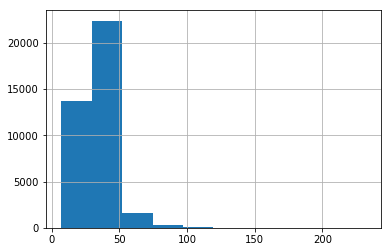

In [36]:
df.life_sq.hist()

In [37]:
 df["apartment_size"] = ["XS" if sz < 10 else "S" if sz < 25 else "M" if sz < 40 else "L" if sz < 55 else "XL" for sz in df.life_sq]

In [38]:
df.apartment_size.describe()

count     38133
unique        5
top           M
freq      13900
Name: apartment_size, dtype: object

# num_room

In [39]:
df.num_room.describe()

count    28561.000000
mean         1.900844
std          0.847620
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: num_room, dtype: float64

## num_room: Small Values (0 rooms)

In [40]:
print df.loc[df.num_room < 1, ["id", "sub_area", "num_room", "apartment_size", "building_size"]], "\n"

ids = df.loc[df.num_room < 1, ["id", "sub_area", "num_room", "apartment_size", "building_size"]].id

df.loc[df.num_room < 1, "num_room"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "num_room", "apartment_size", "building_size"]], "\n"

df["num_room"].fillna(df.groupby("apartment_size")["num_room"].transform("mean"), inplace=True)

df.num_room = df.num_room.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "num_room", "apartment_size", "building_size"]], "\n"

print df.loc[df.floor_ratio < 1, ["id", "sub_area", "num_room", "apartment_size", "building_size"]]

          id                 sub_area  num_room apartment_size building_size
10452  10455           Tekstil'shhiki       0.0              M           Med
11183  11186     Poselenie Shherbinka       0.0              M          High
11791  11794                   Mitino       0.0              L          High
15992  15995     Poselenie Vnukovskoe       0.0              L          High
17932  17935  Poselenie Voskresenskoe       0.0              L           Med
18123  18126        Zapadnoe Degunino       0.0              M           Low
18669  18672     Poselenie Shherbinka       0.0              M           Low
20670  20673               Nekrasovka       0.0              L          High
21439  21442  Poselenie Voskresenskoe       0.0              L           Med
23191  23194     Poselenie Shherbinka       0.0              M          High
24043  24046                  Hovrino       0.0              M          High
24880  24883       Chertanovo Juzhnoe       0.0              S          High

## num_room: Large Values

In [41]:
df.groupby("apartment_size").num_room.agg(["mean", "min", "max"])

,mean,min,max
apartment_size,,,
L,2.184585,1,6
M,1.758777,1,17
S,1.085312,1,19
XL,3.039192,1,9
XS,1.153846,1,2


- Small and medium size apartments have outliers which need to be corrected

In [42]:
print df.loc[(df.num_room > 6) & (df.apartment_size.isin(["S","M"])), ["id", "sub_area", "num_room", "apartment_size", "building_size"]], "\n"
 
ids = df.loc[(df.num_room > 6) & (df.apartment_size.isin(["S","M"])), ["id", "sub_area", "num_room", "apartment_size", "building_size"]].id

df.loc[(df.num_room > 6) & (df.apartment_size.isin(["S","M"])), "num_room"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "num_room", "apartment_size", "building_size"]], "\n"

df["num_room"].fillna(df.groupby("apartment_size")["num_room"].transform("mean"), inplace=True)

df.num_room = df.num_room.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "num_room", "apartment_size", "building_size"]], "\n"

print df.loc[(df.num_room > 6) & (df.apartment_size.isin(["S","M"])), ["id", "sub_area", "num_room", "apartment_size", "building_size"]]

          id              sub_area  num_room apartment_size building_size
11621  11624  Poselenie Vnukovskoe        19              S          High
17764  17767              Krjukovo        10              M           Low
26713  26716          Obruchevskoe        17              M          High
29172  29175               Mar'ino        10              M          High
33645  33648              Kon'kovo        19              S          High 

          id              sub_area  num_room apartment_size building_size
11621  11624  Poselenie Vnukovskoe       NaN              S          High
17764  17767              Krjukovo       NaN              M           Low
26713  26716          Obruchevskoe       NaN              M          High
29172  29175               Mar'ino       NaN              M          High
33645  33648              Kon'kovo       NaN              S          High 

          id              sub_area  num_room apartment_size building_size
11621  11624  Poselenie Vnukovskoe

# build_year

## build_year: Small Values

In [43]:
print df.loc[df.build_year < 1800, ["id", "sub_area", "build_year"]], "\n"

ids = df.loc[df.build_year < 1800, ["id", "sub_area", "build_year"]].id

df.loc[df.build_year < 1800, "build_year"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year"]], "\n"

df["build_year"].fillna(df.groupby("sub_area")["build_year"].transform("mean"), inplace=True)

df.build_year = df.build_year.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year"]], "\n"

print df.loc[df.build_year < 1800, ["id", "sub_area", "build_year"]]

          id                   sub_area  build_year
9441    9444       Poselenie Vnukovskoe         0.0
9620    9623          Zapadnoe Degunino         1.0
9700    9703       Poselenie Vnukovskoe         1.0
9745    9748                 Nekrasovka         1.0
9764    9767                     Mitino         1.0
10122  10125   Poselenie Filimonkovskoe         1.0
10142  10145                 Nekrasovka         0.0
10260  10263       Poselenie Moskovskij         0.0
10294  10297                 Nekrasovka         0.0
10329  10332                    Kuncevo         1.0
10331  10334                     Mitino         0.0
10347  10350       Poselenie Vnukovskoe         0.0
10349  10352             Tekstil'shhiki         0.0
10374  10377        Poselenie Sosenskoe         1.0
10397  10400                 Nekrasovka         1.0
10459  10462    Poselenie Voskresenskoe         1.0
10489  10492                     Mitino         1.0
10594  10597      Pokrovskoe Streshnevo         1.0
10627  10630

## build_year: Large Values

In [44]:
print df.loc[df.build_year > 2019, ["id", "sub_area", "build_year"]], "\n"

ids = df.loc[df.build_year > 2019, ["id", "sub_area", "build_year"]].id

df.loc[df.build_year > 2019, "build_year"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year"]], "\n"

df["build_year"].fillna(df.groupby("sub_area")["build_year"].transform("mean"), inplace=True)

df.build_year = df.build_year.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year"]], "\n"

print df.loc[df.build_year > 2019, ["id", "sub_area", "build_year"]]

          id         sub_area  build_year
251      252      Cheremushki      145195
438      439      Cheremushki      145195
522      523      Cheremushki      145195
1006    1007      Cheremushki      145195
1031    1032      Cheremushki      145195
1201    1202      Cheremushki      145195
1284    1287      Cheremushki      145195
1310    1313      Cheremushki      145195
1352    1355      Cheremushki      145195
1552    1555      Cheremushki      145195
1594    1597      Cheremushki      145195
1640    1643      Cheremushki      145195
1826    1829      Cheremushki      145195
1937    1940      Cheremushki      145195
2006    2009      Cheremushki      145195
2629    2632      Cheremushki      145195
2638    2641      Cheremushki      145195
2646    2649      Cheremushki      145195
2664    2667      Cheremushki      145195
3098    3101      Cheremushki      145195
3109    3112      Cheremushki      145195
3644    3647      Cheremushki      145195
4130    4133      Cheremushki     

# state

In [45]:
df.state.describe()

count    23880.000000
mean         2.071650
std          0.864795
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         33.000000
Name: state, dtype: float64

In [46]:
set(df.state.dropna())

{1.0, 2.0, 3.0, 4.0, 33.0}

In [47]:
print df.loc[df.state > 4, ["id", "sub_area", "build_year", "state", "price_doc"]], "\n"

ids = df.loc[df.state > 4, ["id", "sub_area", "build_year", "state", "price_doc"]].id

df.loc[df.state > 4, "state"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year", "state", "price_doc"]], "\n"

df["state"].fillna(df.groupby("build_year")["state"].transform("mean"), inplace=True)

df.state = df.state.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year", "state", "price_doc"]], "\n"

print df.loc[df.state > 4, ["id", "sub_area", "build_year", "state", "price_doc"]]

          id     sub_area  build_year  state  price_doc
10089  10092  Cheremushki        1980   33.0  9000000.0 

          id     sub_area  build_year  state  price_doc
10089  10092  Cheremushki        1980    NaN  9000000.0 

          id     sub_area  build_year  state  price_doc
10089  10092  Cheremushki        1980      2  9000000.0 

Empty DataFrame
Columns: [id, sub_area, build_year, state, price_doc]
Index: []


In [48]:
set(df.state)

{-9223372036854775808, 1, 2, 3, 4}

In [49]:
print df.loc[df.state < 1, ["id", "sub_area", "build_year", "state"]], "\n"

ids = df.loc[df.state < 1, ["id", "sub_area", "build_year", "state"]].id

df.loc[df.state < 1, "state"] = np.nan

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year", "state"]]

          id sub_area  build_year                state
35352  35355    Arbat        1908 -9223372036854775808 

          id sub_area  build_year  state
35352  35355    Arbat        1908    NaN


In [50]:
mean_state = df.loc[df.build_year.isin([1906,1907,1908,1909,1910]), ["build_year", "state"]].state.mean()

df.loc[df.state.isnull(), ["id", "sub_area", "build_year", "state"]]

,id,sub_area,build_year,state
35352,35355,Arbat,1908,NaN


In [51]:
df["state"].fillna(mean_state, inplace=True)

df.state = df.state.values.astype(int)

print df.loc[df.id.isin(ids), ["id", "sub_area", "build_year", "state"]], "\n"

print df.loc[df.state < 1, ["id", "sub_area", "build_year", "state"]]

          id sub_area  build_year  state
35352  35355    Arbat        1908      2 

Empty DataFrame
Columns: [id, sub_area, build_year, state]
Index: []


# material

In [52]:
df.material.describe()

count    28561.000000
mean         1.834390
std          1.490923
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: material, dtype: float64

In [53]:
set(df.material.dropna())

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0}

In [54]:
print df.loc[df.material.isnull(), ["id", "sub_area", "build_year", "state", "material"]], "\n"

ids = df.loc[df.material.isnull(), ["id", "sub_area", "build_year", "state", "material"]].id

df["material"].fillna(df.groupby("build_year")["material"].transform("mean"), inplace=True)

df.material = df.material.values.astype(int)

print df.loc[df.id.isin(ids),["id", "sub_area", "build_year", "state", "material"]], "\n"

print df.loc[df.material.isnull(), ["id", "sub_area", "build_year", "state", "material"]]

          id                 sub_area  build_year  state  material
0          1                 Bibirevo        1978      2       NaN
1          2        Nagatinskij Zaton        2002      2       NaN
2          3           Tekstil'shhiki        1973      2       NaN
3          4                   Mitino        2004      2       NaN
4          5                Basmannoe        1957      2       NaN
5          6           Nizhegorodskoe        1968      2       NaN
6          7               Sokol'niki        1962      2       NaN
7          8                 Bibirevo        1978      2       NaN
8          9                  Koptevo        1975      2       NaN
9         10                  Kuncevo        1982      2       NaN
10        11         Kosino-Uhtomskoe        2003      2       NaN
11        12        Zapadnoe Degunino        2001      2       NaN
12        13                  Kuncevo        1982      2       NaN
13        14              Presnenskoe        1971      2      

# timestamp

In [55]:
df.timestamp.describe()

count                   38133
unique                   1435
top       2014-12-16 00:00:00
freq                      160
first     2011-08-20 00:00:00
last      2016-05-30 00:00:00
Name: timestamp, dtype: object

## month - NEW FEATURE
- Extracting the month from timestamp

In [56]:
df['month'] = df.loc[:, 'timestamp'].apply(lambda x: x.month)

print np.sort(df.month.unique())

df.month.describe()

[ 1  2  3  4  5  6  7  8  9 10 11 12]


count    38133.000000
mean         6.616920
std          3.620018
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

## year - NEW FEATURE
- Extracting the year from timestamp

In [57]:
df['year'] = df.loc[:, 'timestamp'].apply(lambda x: x.year)

print np.sort(df.year.unique())

df.year.describe()

[2011 2012 2013 2014 2015 2016]


count    38133.000000
mean      2013.868067
std          1.215063
min       2011.000000
25%       2013.000000
50%       2014.000000
75%       2015.000000
max       2016.000000
Name: year, dtype: float64

# season - NEW FEATURE
- Determining the season based on month of the year as below:
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June. July, August
    - Fall: September, October, November

In [58]:
df["season"] = ["Winter" if x in [12,1,2,] else "Spring" if x in [3,4,5] else "Summer" if x in [6,7,8] else "Fall" for x in df.month]

print df.season.unique()

df.season.describe()

['Summer' 'Fall' 'Winter' 'Spring']


count      38133
unique         4
top       Spring
freq       10581
Name: season, dtype: object

# days_since_start - NEW FEATURE
- Converting timestamp into a continuous variable as days since the day of the first transaction of the data set.

In [59]:
df["days_since_start"] = map(lambda date: (date - df.timestamp[0]).days, df.timestamp)

In [60]:
df.days_since_start.describe()

count    38133.000000
mean      1002.293001
std        422.851595
min          0.000000
25%        711.000000
50%       1013.000000
75%       1313.000000
max       1745.000000
Name: days_since_start, dtype: float64

# metro_min_avto

In [61]:
df.metro_min_avto.describe()

count    38133.000000
mean         4.902702
std          6.473965
min          0.000000
25%          1.719313
50%          2.769542
75%          4.788853
max         65.101125
Name: metro_min_avto, dtype: float64

- Imputing '0' values

In [62]:
print df.loc[df.metro_min_avto == 0, ["id", "sub_area", "metro_min_avto"]], "\n"

ids = df.loc[df.metro_min_avto == 0, ["id", "sub_area", "metro_min_avto"]].id

df.loc[df.metro_min_avto == 0, "metro_min_avto"] = np.nan

print df.loc[df.id.isin(ids),["id", "sub_area", "metro_min_avto"]], "\n"

df["metro_min_avto"].fillna(df.groupby("sub_area")["metro_min_avto"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids),["id", "sub_area", "metro_min_avto"]], "\n"

print df.loc[df.metro_min_avto == 0, ["id", "sub_area", "metro_min_avto"]]

          id  sub_area  metro_min_avto
21482  21485  Nagornoe             0.0 

          id  sub_area  metro_min_avto
21482  21485  Nagornoe             NaN 

          id  sub_area  metro_min_avto
21482  21485  Nagornoe         1.11938 

Empty DataFrame
Columns: [id, sub_area, metro_min_avto]
Index: []


# km features
- Imputing all distance related features with '0' values

In [63]:
for col in df.columns:
    if col.find("km") >= 0:
        
        print col, "\n"
        
        print df[col].describe(), "\n"

        print df.loc[df[col] == 0, ["id", "sub_area", col]], "\n"

        ids = df.loc[df[col] == 0, ["id", "sub_area", col]].id

        df.loc[df[col] == 0, col] = np.nan
        
        print df.loc[df.id.isin(ids),["id", "sub_area", col]], "\n"

        df[col].fillna(df.groupby("sub_area")[col].transform("mean"), inplace=True)

        print df.loc[df.id.isin(ids),["id", "sub_area", col]], "\n"

        print df.loc[df[col] == 0, ["id", "sub_area", col]], "\n"

metro_km_avto 

count    38133.000000
mean         3.682997
std          5.837937
min          0.000000
25%          1.036568
50%          1.770572
75%          3.776836
max         74.905763
Name: metro_km_avto, dtype: float64 

          id  sub_area  metro_km_avto
21482  21485  Nagornoe            0.0 

          id  sub_area  metro_km_avto
21482  21485  Nagornoe            NaN 

          id  sub_area  metro_km_avto
21482  21485  Nagornoe       0.699909 

Empty DataFrame
Columns: [id, sub_area, metro_km_avto]
Index: [] 

metro_km_walk 

count    38074.000000
mean         3.553842
std          5.900921
min          0.000000
25%          0.953654
50%          1.680527
75%          3.633209
max         59.267984
Name: metro_km_walk, dtype: float64 

          id  sub_area  metro_km_walk
21482  21485  Nagornoe            0.0 

          id  sub_area  metro_km_walk
21482  21485  Nagornoe            NaN 

          id  sub_area  metro_km_walk
21482  21485  Nagornoe       0.598089 

Empty

# metro_min_walk

In [64]:
print df.loc[df.metro_min_walk.isnull(), ["id", "sub_area", "metro_min_walk"]], "\n"

ids = df.loc[df.metro_min_walk.isnull(), ["id", "sub_area", "metro_min_walk"]].id

df["metro_min_walk"].fillna(df.groupby("sub_area")["metro_min_walk"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids),["id", "sub_area", "metro_min_walk"]], "\n"

print df.loc[df[col] == 0, ["id", "sub_area", "metro_min_walk"]], "\n"

          id              sub_area  metro_min_walk
10709  10712        Timirjazevskoe             NaN
13259  13262        Timirjazevskoe             NaN
13699  13702               Begovoe             NaN
14796  14799        Timirjazevskoe             NaN
15790  15793            Vojkovskoe             NaN
17358  17361        Timirjazevskoe             NaN
18255  18258               Begovoe             NaN
19344  19347        Timirjazevskoe             NaN
19370  19373        Timirjazevskoe             NaN
19477  19480        Timirjazevskoe             NaN
21593  21596            Vojkovskoe             NaN
21717  21720        Timirjazevskoe             NaN
24553  24556  Ochakovo-Matveevskoe             NaN
26944  26947  Poselenie Vnukovskoe             NaN
27004  27007        Timirjazevskoe             NaN
27199  27202  Ochakovo-Matveevskoe             NaN
27875  27878  Poselenie Vnukovskoe             NaN
28213  28216        Timirjazevskoe             NaN
28669  28672  Poselenie Vnukovs

# railroad_station_walk_min

In [65]:
print df.loc[df.railroad_station_walk_min.isnull(), ["id", "sub_area", "railroad_station_walk_min"]], "\n"

ids = df.loc[df.railroad_station_walk_min.isnull(), ["id", "sub_area", "railroad_station_walk_min"]].id

df["railroad_station_walk_min"].fillna(df.groupby("sub_area")["railroad_station_walk_min"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids),["id", "sub_area", "railroad_station_walk_min"]], "\n"

print df.loc[df.railroad_station_walk_min.isnull(), ["id", "sub_area", "railroad_station_walk_min"]]

          id              sub_area  railroad_station_walk_min
10709  10712        Timirjazevskoe                        NaN
13259  13262        Timirjazevskoe                        NaN
13699  13702               Begovoe                        NaN
14796  14799        Timirjazevskoe                        NaN
15790  15793            Vojkovskoe                        NaN
17358  17361        Timirjazevskoe                        NaN
18255  18258               Begovoe                        NaN
19344  19347        Timirjazevskoe                        NaN
19370  19373        Timirjazevskoe                        NaN
19477  19480        Timirjazevskoe                        NaN
21593  21596            Vojkovskoe                        NaN
21717  21720        Timirjazevskoe                        NaN
24553  24556  Ochakovo-Matveevskoe                        NaN
26944  26947  Poselenie Vnukovskoe                        NaN
27004  27007        Timirjazevskoe                        NaN
27199  2

# ID_railroad_station_walk

In [66]:
print df.loc[df.ID_railroad_station_walk.isnull(), ["id", "sub_area", "ID_railroad_station_walk"]], "\n"

ids = df.loc[df.ID_railroad_station_walk.isnull(), ["id", "sub_area", "ID_railroad_station_walk"]].id

df["ID_railroad_station_walk"].fillna(df.groupby("sub_area")["ID_railroad_station_walk"].transform("mean"), inplace=True)

df.ID_railroad_station_walk = df.ID_railroad_station_walk.values.astype(int)

print df.loc[df.id.isin(ids),["id", "sub_area", "ID_railroad_station_walk"]], "\n"

print df.loc[df.ID_railroad_station_walk.isnull(), ["id", "sub_area", "ID_railroad_station_walk"]]

          id              sub_area  ID_railroad_station_walk
10709  10712        Timirjazevskoe                       NaN
13259  13262        Timirjazevskoe                       NaN
13699  13702               Begovoe                       NaN
14796  14799        Timirjazevskoe                       NaN
15790  15793            Vojkovskoe                       NaN
17358  17361        Timirjazevskoe                       NaN
18255  18258               Begovoe                       NaN
19344  19347        Timirjazevskoe                       NaN
19370  19373        Timirjazevskoe                       NaN
19477  19480        Timirjazevskoe                       NaN
21593  21596            Vojkovskoe                       NaN
21717  21720        Timirjazevskoe                       NaN
24553  24556  Ochakovo-Matveevskoe                       NaN
26944  26947  Poselenie Vnukovskoe                       NaN
27004  27007        Timirjazevskoe                       NaN
27199  27202  Ochakovo-M

# cafe_avg_price features

In [67]:
for col in df.columns:
    
    if col.find("cafe") >= 0 and df[col].isnull().sum() > 0:
                
        print col, "\n"
        
        print df[col].describe(), "\n"

        print df.loc[df[col].isnull(), ["id", "sub_area", col]], "\n"

        ids = df.loc[df[col].isnull(), ["id", "sub_area", col]].id

        df.loc[df[col].isnull(), col] = np.nan
        
        print df.loc[df.id.isin(ids),["id", "sub_area", col]], "\n"

        df[col].fillna(df.groupby("sub_area")[col].transform("mean"), inplace=True)

        print df.loc[df.id.isin(ids),["id", "sub_area", col]], "\n"

        print df.loc[df[col].isnull(), ["id", "sub_area", col]], "\n"


cafe_sum_500_min_price_avg 

count    21693.000000
mean       743.660153
std        339.947751
min        300.000000
25%        500.000000
50%        668.750000
75%        977.780000
max       4000.000000
Name: cafe_sum_500_min_price_avg, dtype: float64 

          id                 sub_area  cafe_sum_500_min_price_avg
0          1                 Bibirevo                         NaN
11        12        Zapadnoe Degunino                         NaN
16        17                Kuz'minki                         NaN
20        21                  Vnukovo                         NaN
25        26           Fili Davydkovo                         NaN
28        29              Bogorodskoe                         NaN
31        32                  Hovrino                         NaN
34        35          Staroe Krjukovo                         NaN
35        36                  Mar'ino                         NaN
39        40                Veshnjaki                         NaN
41        42      

# prom_part_5000

In [68]:
df.prom_part_5000.describe()

count    37863.000000
mean        10.499062
std          5.765588
min          0.210000
25%          6.070000
50%          9.490000
75%         14.240000
max         28.590000
Name: prom_part_5000, dtype: float64

In [69]:
df.prom_part_5000.isnull().sum()

270

In [70]:
print df.loc[df.prom_part_5000.isnull(), ["id", "sub_area", "prom_part_5000"]], "\n"

ids = df.loc[df.prom_part_5000.isnull(), ["id", "sub_area", "prom_part_5000"]].id

df["prom_part_5000"].fillna(df.groupby("sub_area")["prom_part_5000"].transform("mean"), inplace=True)

print df.loc[df.id.isin(ids),["id", "sub_area", "prom_part_5000"]], "\n"

print df.loc[df[col].isnull(), ["id", "sub_area", "prom_part_5000"]], "\n"

          id                   sub_area  prom_part_5000
11701  11704                 Vostochnoe             NaN
12742  12745        Poselenie Rogovskoe             NaN
12770  12773  Poselenie Novofedorovskoe             NaN
14440  14443  Poselenie Novofedorovskoe             NaN
14534  14537  Poselenie Novofedorovskoe             NaN
14685  14688        Poselenie Rogovskoe             NaN
14729  14732        Poselenie Rogovskoe             NaN
14768  14771  Poselenie Novofedorovskoe             NaN
14895  14898        Poselenie Rogovskoe             NaN
15868  15871        Poselenie Rogovskoe             NaN
15901  15904  Poselenie Novofedorovskoe             NaN
15902  15905        Poselenie Rogovskoe             NaN
16163  16166  Poselenie Novofedorovskoe             NaN
16176  16179  Poselenie Novofedorovskoe             NaN
16363  16366  Poselenie Novofedorovskoe             NaN
16671  16674  Poselenie Novofedorovskoe             NaN
16790  16793        Poselenie Rogovskoe         

# child_on_acc_pre_school

In [71]:
df.child_on_acc_pre_school.unique()

array(['#!', '7,311', '3,013', '16,765', nan], dtype=object)

In [72]:
df.loc[df.child_on_acc_pre_school == '#!', "child_on_acc_pre_school"] = np.nan

In [73]:
df.child_on_acc_pre_school.unique()

array([nan, '7,311', '3,013', '16,765'], dtype=object)

In [74]:
df.loc[df.child_on_acc_pre_school.isnull() != True, 
       "child_on_acc_pre_school"] = map(lambda x: int(x.replace(",", "")), 
                                        df.loc[df.child_on_acc_pre_school.isnull() != True, "child_on_acc_pre_school"])

In [75]:
df.child_on_acc_pre_school = df.child_on_acc_pre_school.astype(float)

In [76]:
df.child_on_acc_pre_school.unique()

array([    nan,   7311.,   3013.,  16765.])

# modern_education_share

In [77]:
df.modern_education_share.unique()

array([nan, '90,92', '93,08', '95,4918'], dtype=object)

In [78]:
df.loc[df.modern_education_share.isnull() != True, 
        "modern_education_share"] = map(lambda x: float(x.replace(",", ".")), 
                                        df.loc[df.modern_education_share.isnull() != True, "modern_education_share"])

In [79]:
df.modern_education_share = df.modern_education_share.astype(float)

In [80]:
df.modern_education_share.unique()

array([     nan,  90.92  ,  93.08  ,  95.4918])

# old_education_build_share

In [81]:
df.old_education_build_share.unique()

array([nan, '23,14', '25,47', '8,2517'], dtype=object)

In [82]:
df.loc[df.old_education_build_share.isnull() != True, 
        "old_education_build_share"] = map(lambda x: float(x.replace(",", ".")), 
                                         df.loc[df.old_education_build_share.isnull() != True, "old_education_build_share"])

In [83]:
df.old_education_build_share = df.old_education_build_share.astype(float)

In [84]:
df.old_education_build_share.unique()

array([     nan,  23.14  ,  25.47  ,   8.2517])

# apartment_build

In [85]:
df.apartment_build.describe()

count    27232.000000
mean     44910.638807
std       3854.550878
min      23587.000000
25%      46080.000000
50%      46080.000000
75%      46352.000000
max      46352.000000
Name: apartment_build, dtype: float64

In [86]:
print df.loc[df.apartment_build.isnull(), ["id", "sub_area", "apartment_build", "year"]], "\n"

ids = df.loc[df.apartment_build.isnull(), ["id", "sub_area", "apartment_build", "year"]].id

df["apartment_build"].fillna(df.groupby("sub_area")["apartment_build"].transform("mean"), inplace=True)

df.apartment_build = df.apartment_build.values.astype(int)

print df.loc[df.id.isin(ids),["id", "sub_area", "apartment_build", "year"]], "\n"

print df.loc[df.apartment_build.isnull(), ["id", "sub_area", "apartment_build", "year"]]

          id                  sub_area  apartment_build  year
27232  27235      Poselenie Vnukovskoe              NaN  2015
27233  27236      Poselenie Vnukovskoe              NaN  2015
27234  27237      Poselenie Moskovskij              NaN  2015
27235  27238       Poselenie Sosenskoe              NaN  2015
27236  27239            Akademicheskoe              NaN  2015
27237  27240                  Caricyno              NaN  2015
27238  27241         Zapadnoe Degunino              NaN  2015
27239  27242         Zapadnoe Degunino              NaN  2015
27240  27243       Poselenie Sosenskoe              NaN  2015
27241  27244                  Kon'kovo              NaN  2015
27242  27245      Poselenie Vnukovskoe              NaN  2015
27243  27246           Preobrazhenskoe              NaN  2015
27244  27247       Poselenie Sosenskoe              NaN  2015
27245  27248      Poselenie Vnukovskoe              NaN  2015
27246  27249      Poselenie Moskovskij              NaN  2015
27247  2

# Features with un-imputed missing values

- Dropping any feature with 10,000 or more missing values

In [87]:
print df.shape

for col in df.columns:
    
    if df[col].isnull().sum() > 9999:
        df = df.drop(col, axis =1)
        
print df.shape

(38133, 399)
(38133, 359)


- Writing full merged data set to a csv file

In [88]:
#df.to_csv("./data/full_new_features.csv", index = False)

# Modelling using Xgboost

- Splitting data set back into Train and Test

In [89]:
train = df.loc[df.SOURCE == "TRAIN", ]
test = df.loc[df.SOURCE == "TEST", ]

In [90]:
train.head(2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_200

In [91]:
test.head(2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_200

- Label encoding categorical features

In [92]:
for f in train.columns:
    if train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)) 
        train[f] = lbl.transform(list(train[f].values))
        
for f in test.columns:
    if test[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test[f].values)) 
        test[f] = lbl.transform(list(test[f].values))

- Preparing training and test data to be use dto fit xgb model

In [93]:
X_train = train.drop(['id', 'timestamp', 'price_doc'],axis=1)
X_test = test.drop(['id', 'timestamp','price_doc'],axis=1)

Y_train = np.log1p(train.price_doc.values)

dtrain = xgb.DMatrix(X_train, Y_train)

## Grid Search Cross Validation

In [97]:
model = XGBRegressor(nthread = -1)

gs = model_selection.GridSearchCV(model,
                 {"learning_rate": [0.05, 0.1],
                 "max_depth": [5, 6],
                 "n_estimators": [100, 200],
                  "subsample": [0.7],
                  "colsample_bytree": [0.5],
                 },
                                  cv = 5,
                                  n_jobs = 10,
                                  verbose = 1)

gs.fit(X_train, Y_train)

print gs.best_score_
print gs.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:  6.3min finished


0.394314683576
{'n_estimators': 200, 'subsample': 0.7, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'max_depth': 5}


## XGboost Cross Validation

In [100]:
params = {"booster":"gbtree",
          "eta": 0.1,
          "n_estimators": 200,
          "max_depth": 5,
          "subsample": 0.7,
          "colsample_bytree": 0.5,
          "objective": 'reg:linear',
          "eval_metric": 'rmse',
          "seed": 1,
          "silent": 0}

cv = xgb.cv(params, 
                dtrain, 
                num_boost_round=10000,
                nfold = 5, 
                early_stopping_rounds = 50,
                verbose_eval = 50)

num_boost = cv.loc[cv["test-rmse-mean"] == min(cv["test-rmse-mean"])].index[0]
print cv.loc[cv["test-rmse-mean"] == min(cv["test-rmse-mean"])].index[0], "\n"
print num_boost
print cv.loc[cv["test-rmse-mean"] == min(cv["test-rmse-mean"])]

[0]	train-rmse:13.6118+0.00137596	test-rmse:13.6118+0.0061491
[50]	train-rmse:0.443399+0.00122107	test-rmse:0.472549+0.0042174
[100]	train-rmse:0.408743+0.00185847	test-rmse:0.462809+0.0043506
[150]	train-rmse:0.387178+0.00209983	test-rmse:0.462638+0.0044774
[200]	train-rmse:0.368576+0.00204406	test-rmse:0.462808+0.00413075
176 

176
     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
176        0.462393       0.004256         0.377792        0.002022


- Time to train the model

In [102]:
gbm = xgb.train(dtrain = dtrain, params = params, num_boost_round = num_boost)

- Predicting Y_test

In [ ]:
Y_test = gbm.predict(xgb.DMatrix(X_test))

- Preparing Data Frame of "id" and "price_doc" for submission to Kaggle

In [ ]:
submission = pd.DataFrame()
submission['id'] = test["id"]
submission["price_doc"] = np.expm1(Y_test)

- Writing to csv file for submission to Kaggle

In [ ]:
submission.to_csv("~/Desktop/SubmissionX.csv", index = False)